<a href="https://colab.research.google.com/github/hamednasr/tensorflow/blob/main/06_transfer_learning_in_tensorflow_part3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Food 101 classification model:

In [1]:
 import tensorflow as tf

In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-03-10 08:15:20--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-03-10 08:15:20 (71.7 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
from helper_functions import compare_historys, create_tensorboard_callback,plot_loss_curves,unzip_data,walk_through_dir 

In [4]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip

--2022-03-10 08:15:21--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.125.128, 142.250.157.128, 142.251.8.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.125.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G  97.8MB/s    in 18s     

2022-03-10 08:15:39 (87.6 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [5]:
unzip_data('101_food_classes_10_percent.zip')

In [6]:
train_data_10percent = tf.keras.preprocessing.image_dataset_from_directory\
('/content/101_food_classes_10_percent/train',
 label_mode='categorical',
 image_size=(224,224))

Found 7575 files belonging to 101 classes.


In [7]:
test_data = tf.keras.preprocessing.image_dataset_from_directory\
('/content/101_food_classes_10_percent/test',
 label_mode='categorical',
 image_size=(224,224),shuffle=False)

Found 25250 files belonging to 101 classes.


In [8]:
walk_through_dir('101_food_classes_10_percent')

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/test'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/ceviche'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/scallops'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/lobster_roll_sandwich'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/miso_soup'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/dumplings'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/peking_duck'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/lobster_bisque'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in 

In [9]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('model101_10percent_checkpoint',
                                                save_weights_only=True,
                                                monitor='val_accuracy',
                                                save_best_only=True)

In [10]:
data_augmentation = tf.keras.Sequential([
                    tf.keras.layers.RandomFlip('horizontal'),
                    tf.keras.layers.RandomRotation(0.2),
                    tf.keras.layers.RandomZoom(0.2),
                    tf.keras.layers.RandomHeight(0.2),
                    tf.keras.layers.RandomWidth(0.2)], 
                    name ="data_augmentation")

## feature extractor model:

In [11]:
base_model = tf.keras.applications.EfficientNetB0(include_top=False,pooling='avg')
base_model.trainable = False

inputs = tf.keras.layers.Input(shape=(224,224,3),name='input_layer')

x = data_augmentation(inputs)

x = base_model(x)
print(x.shape)
outputs = tf.keras.layers.Dense(101,activation='softmax',name='output_layer')(x)

model_101FE = tf.keras.Model(inputs,outputs,name='model_101FE')

model_101FE.compile(loss = 'categorical_crossentropy',
                  optimizer = tf.keras.optimizers.Adam(),
                  metrics = ['accuracy'])

model_101FE.summary()

16719872/16705208 [==============================] - 1s 0us/step
(None, 1280)
Model: "model_101FE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, 1280)             4049571   
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
_________________________________________________________________


In [12]:
len(model_101FE.trainable_variables)

2

In [13]:
model_101FEcheck=tf.keras.callbacks.ModelCheckpoint(
                                    '/content/checkpoints/model_101FE.ckpt',
                                    save_weights_only=True,
                                    save_best_only=True,
                                    monitor='val_accuracy')

In [14]:
history_model_101FE=model_101FE.fit(train_data_10percent,
                                     epochs=5,
                                     validation_data=test_data,
                                     validation_steps = int(0.15*len(test_data)),
                                     callbacks=[create_tensorboard_callback(dir_name='tensorboard',experiment_name='model_101FE'),
                                                model_101FEcheck])

Saving TensorBoard log files to: tensorboard/model_101FE/20220310-081721
Epoch 1/5
237/237 [==============================] - 143s 523ms/step - loss: 3.5274 - accuracy: 0.2309 - val_loss: 2.6433 - val_accuracy: 0.4208
Epoch 2/5
237/237 [==============================] - 99s 415ms/step - loss: 2.4341 - accuracy: 0.4437 - val_loss: 2.1776 - val_accuracy: 0.4780
Epoch 3/5
237/237 [==============================] - 90s 379ms/step - loss: 2.0528 - accuracy: 0.5129 - val_loss: 2.0569 - val_accuracy: 0.4841
Epoch 4/5
237/237 [==============================] - 88s 369ms/step - loss: 1.8506 - accuracy: 0.5538 - val_loss: 1.9470 - val_accuracy: 0.5005
Epoch 5/5
237/237 [==============================] - 79s 331ms/step - loss: 1.6995 - accuracy: 0.5840 - val_loss: 1.9097 - val_accuracy: 0.5016


In [15]:
model_101FE.evaluate(test_data)

790/790 [==============================] - 106s 134ms/step - loss: 1.7373 - accuracy: 0.5457


[1.7372567653656006, 0.5456633567810059]

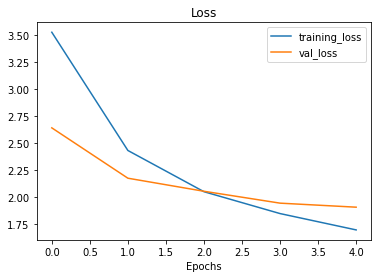

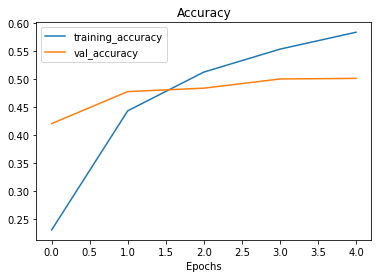

In [16]:
plot_loss_curves(history_model_101FE)

In [17]:
model_101FE.save('/content/drive/MyDrive/Colab Notebooks/Tensorflow course/model_101EF.h5')

## train Dense layer for 5 more epochs:

In [19]:
model_101FE2 = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/Tensorflow course/model_101EF.h5')

In [20]:
history_model_101FE2=model_101FE2.fit(train_data_10percent,
                                     epochs=10,
                                     initial_epoch=5,
                                     validation_data=test_data,
                                     validation_steps = int(0.15*len(test_data)),
                                     callbacks=[create_tensorboard_callback(dir_name='tensorboard',experiment_name='model_101FE'),
                                                model_101FEcheck])

Saving TensorBoard log files to: tensorboard/model_101FE/20220310-082953
Epoch 6/10
237/237 [==============================] - 89s 342ms/step - loss: 1.6006 - accuracy: 0.6018 - val_loss: 1.9130 - val_accuracy: 0.4974
Epoch 7/10
237/237 [==============================] - 77s 324ms/step - loss: 1.4769 - accuracy: 0.6326 - val_loss: 1.8786 - val_accuracy: 0.5087
Epoch 8/10
237/237 [==============================] - 72s 301ms/step - loss: 1.4096 - accuracy: 0.6467 - val_loss: 1.8453 - val_accuracy: 0.5143
Epoch 9/10
237/237 [==============================] - 70s 295ms/step - loss: 1.3303 - accuracy: 0.6655 - val_loss: 1.8382 - val_accuracy: 0.5188
Epoch 10/10
237/237 [==============================] - 72s 302ms/step - loss: 1.2667 - accuracy: 0.6817 - val_loss: 1.8310 - val_accuracy: 0.5167


In [21]:
model_101FE2.evaluate(test_data)

790/790 [==============================] - 104s 131ms/step - loss: 1.6469 - accuracy: 0.5613


[1.646888017654419, 0.5613465309143066]

## Fine tuning 20 last layers of base model in model_101FE for 5 more epochs:

In [ ]:
# base_model = tf.keras.applications.EfficientNetB0(include_top=False,pooling='avg')
# #base_model.trainable = False

# inputs = tf.keras.layers.Input(shape=(224,224,3),name='input_layer')

# x = data_augmentation(inputs)

# x = base_model(x, training=False)
# print(x.shape)
# outputs = tf.keras.layers.Dense(101,activation='softmax',name='output_layer')(x)

# model_101FT = tf.keras.Model(inputs,outputs,name='model_101FT')

# model_101FT.compile(loss = 'categorical_crossentropy',
#                   optimizer = tf.keras.optimizers.Adam(),
#                   metrics = ['accuracy'])

# model_101FT.summary()

(None, 1280)
Model: "model_101FT"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, 1280)             4049571   
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 4,136,929
Non-trainable params: 42,023
_________________________________________________________________


In [ ]:
#reload the previous model weights
# model_101FT.load_weights('/content/checkpoints/model_101FE.ckpt')

In [41]:
model_101FT = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/Tensorflow course/model_101EF.h5')

In [42]:
for layer in model_101FT.layers[2].layers:
  print(layer.name, layer.trainable)

input_1 True
rescaling False
normalization False
stem_conv_pad False
stem_conv False
stem_bn False
stem_activation False
block1a_dwconv False
block1a_bn False
block1a_activation False
block1a_se_squeeze False
block1a_se_reshape False
block1a_se_reduce False
block1a_se_expand False
block1a_se_excite False
block1a_project_conv False
block1a_project_bn False
block2a_expand_conv False
block2a_expand_bn False
block2a_expand_activation False
block2a_dwconv_pad False
block2a_dwconv False
block2a_bn False
block2a_activation False
block2a_se_squeeze False
block2a_se_reshape False
block2a_se_reduce False
block2a_se_expand False
block2a_se_excite False
block2a_project_conv False
block2a_project_bn False
block2b_expand_conv False
block2b_expand_bn False
block2b_expand_activation False
block2b_dwconv False
block2b_bn False
block2b_activation False
block2b_se_squeeze False
block2b_se_reshape False
block2b_se_reduce False
block2b_se_expand False
block2b_se_excite False
block2b_project_conv False
bloc

In [43]:
for layer in model_101FT.layers[2].layers[-20:]:
  layer.trainable=True

In [44]:
for layer in model_101FT.layers[2].layers:
  print(layer.name, layer.trainable)

input_1 True
rescaling False
normalization False
stem_conv_pad False
stem_conv False
stem_bn False
stem_activation False
block1a_dwconv False
block1a_bn False
block1a_activation False
block1a_se_squeeze False
block1a_se_reshape False
block1a_se_reduce False
block1a_se_expand False
block1a_se_excite False
block1a_project_conv False
block1a_project_bn False
block2a_expand_conv False
block2a_expand_bn False
block2a_expand_activation False
block2a_dwconv_pad False
block2a_dwconv False
block2a_bn False
block2a_activation False
block2a_se_squeeze False
block2a_se_reshape False
block2a_se_reduce False
block2a_se_expand False
block2a_se_excite False
block2a_project_conv False
block2a_project_bn False
block2b_expand_conv False
block2b_expand_bn False
block2b_expand_activation False
block2b_dwconv False
block2b_bn False
block2b_activation False
block2b_se_squeeze False
block2b_se_reshape False
block2b_se_reduce False
block2b_se_expand False
block2b_se_excite False
block2b_project_conv False
bloc

In [45]:
len(model_101FT.trainable_variables)

20

In [46]:
model_101FT.summary()

Model: "model_101FE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, 1280)             4049571   
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 1,259,157
Non-trainable params: 2,919,795
_________________________________________________________________


In [47]:
model_101FTcheck=tf.keras.callbacks.ModelCheckpoint(
                                    '/content/checkpoints/model_101FT.ckpt',
                                    save_weights_only=True,
                                    save_best_only=True,
                                    monitor='val_accuracy')

In [48]:
model_101FT.compile(loss = 'categorical_crossentropy',
                  optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
                  metrics = ['accuracy'])

In [49]:
history_model_101FT=model_101FT.fit(train_data_10percent,
                                     epochs=10,
                                     initial_epoch = 5,
                                     validation_data=test_data,
                                     validation_steps = int(0.15*len(test_data)),
                                     callbacks=[create_tensorboard_callback(dir_name='tensorboard',experiment_name='model_101FT'),
                                                model_101FTcheck])

Saving TensorBoard log files to: tensorboard/model_101FT/20220310-084813
Epoch 6/10
237/237 [==============================] - 85s 279ms/step - loss: 1.8664 - accuracy: 0.5154 - val_loss: 2.2632 - val_accuracy: 0.4650
Epoch 7/10
237/237 [==============================] - 70s 294ms/step - loss: 1.3430 - accuracy: 0.6433 - val_loss: 1.8999 - val_accuracy: 0.5281
Epoch 8/10
237/237 [==============================] - 64s 269ms/step - loss: 1.0797 - accuracy: 0.7030 - val_loss: 1.9525 - val_accuracy: 0.5278
Epoch 9/10
237/237 [==============================] - 68s 285ms/step - loss: 0.8613 - accuracy: 0.7669 - val_loss: 1.8990 - val_accuracy: 0.5429
Epoch 10/10
237/237 [==============================] - 62s 261ms/step - loss: 0.7077 - accuracy: 0.8062 - val_loss: 2.1525 - val_accuracy: 0.5011


In [50]:
model_101FT.evaluate(test_data)

790/790 [==============================] - 104s 131ms/step - loss: 1.7976 - accuracy: 0.5672


[1.7975945472717285, 0.5671682953834534]

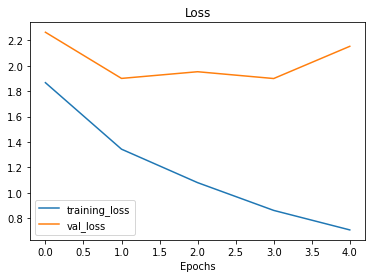

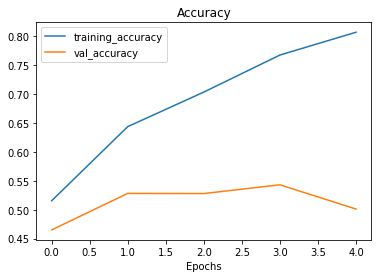

In [51]:
plot_loss_curves(history_model_101FT)

## save and load our model:

In [ ]:
model_101FT.save('/content/drive/MyDrive/Colab Notebooks/Tensorflow course/model_101FT.h5')

In [ ]:
loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/Tensorflow course/model_101FT.h5')

In [ ]:
loaded_model.evaluate(test_data)

In [ ]:
loaded_model.summary()

Model: "model_101FT"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, 1280)             4049571   
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 1,259,157
Non-trainable params: 2,919,795
_________________________________________________________________


In [ ]:
len(loaded_model.trainable_variables)

20

In [ ]:
for layer in loaded_model.layers:
  print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7ff0a7a33290> True
<keras.engine.sequential.Sequential object at 0x7ff0a7a334d0> True
<keras.engine.functional.Functional object at 0x7ff0a7a33810> True
<keras.layers.core.dense.Dense object at 0x7ff125856650> True


In [ ]:
preds_prob = loaded_model.predict(test_data.take(3))
preds_prob.shape

(96, 101)

In [ ]:
tf.argmax(preds_prob[75])

<tf.Tensor: shape=(), dtype=int64, numpy=12>

## load and prepare a custom image:

In [ ]:
def load_prep_image(filmename, img_shape, scale= True):
  '''
  reads an image from file name turns it into tensor and reshapes into 
  specified shape (img_shape, img_shape, channels = 3).

  Args: 
    filename (str): path to target image,
    img_shape (int): height/width dimentions of target image size
    scale (bool): scale pixel values from 0-255 to 0-1 or not 

  Returns:
    Image tensor of shape (img_shape, img_shape, channels = 3)
  '''
  # read in the target image
  img = tf.io.read_file(filmename)

  # decode image into tensor
  img = tf.io.decode_image(img, channels=3)

  img = tf.image.resize(img, [img_shape, img_shape])

  if scale:
    return img/255

  else:
    return img    

In [ ]:
import matplotlib.pyplot as plt
import random

In [ ]:
test_data.class_names

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheese_plate',
 'cheesecake',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

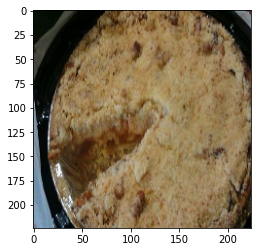

In [ ]:
for image, label  in test_data:
  img = random.choice(image)/255
  break
plt.imshow(img)

In [ ]:
pred = loaded_model.predict(tf.expand_dims(img,0))[0]
pred

array([0.02785691, 0.00462981, 0.02347637, 0.00727275, 0.01234874,
       0.03850645, 0.0143657 , 0.00506402, 0.01082037, 0.00291937,
       0.00335396, 0.00298192, 0.00786361, 0.01254656, 0.00637596,
       0.01104423, 0.00857596, 0.00701789, 0.00240189, 0.01453354,
       0.00746186, 0.0046102 , 0.00721153, 0.02201316, 0.01317652,
       0.00346246, 0.00267119, 0.00562031, 0.00487103, 0.00268977,
       0.00975619, 0.00197715, 0.0016604 , 0.01822698, 0.00236944,
       0.0048376 , 0.0017901 , 0.00505634, 0.00371657, 0.01928467,
       0.00955905, 0.03014312, 0.00191456, 0.00681338, 0.00549213,
       0.00472286, 0.00066259, 0.01159469, 0.00095571, 0.00333228,
       0.00471721, 0.0110416 , 0.01601055, 0.0084947 , 0.01366999,
       0.00091417, 0.00168644, 0.00231553, 0.00343511, 0.00949969,
       0.02887086, 0.00982541, 0.01577172, 0.02993395, 0.10363194,
       0.00134918, 0.00828838, 0.00059867, 0.00153975, 0.00535634,
       0.00870053, 0.01067507, 0.00145804, 0.02198353, 0.00624

In [ ]:
tf.argmax(pred)

<tf.Tensor: shape=(), dtype=float32, numpy=0.10363194>

In [ ]:
img = plt.imread('/content/101_food_classes_10_percent/test/baklava/1028777.jpg')/255

In [ ]:
img = tf.image.resize(img, (224,224))
img

<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
array([[[0.7411765 , 0.7607843 , 0.74509805],
        [0.7411765 , 0.7607843 , 0.74509805],
        [0.7411765 , 0.7607843 , 0.74509805],
        ...,
        [0.6624649 , 0.7014005 , 0.6478991 ],
        [0.65798324, 0.69691885, 0.6434174 ],
        [0.6630254 , 0.701961  , 0.64845955]],

       [[0.7411765 , 0.7607843 , 0.74509805],
        [0.7411765 , 0.7607843 , 0.74509805],
        [0.7411765 , 0.7607843 , 0.74509805],
        ...,
        [0.6627451 , 0.7058824 , 0.6509804 ],
        [0.65882355, 0.7019608 , 0.64705884],
        [0.65882355, 0.7019608 , 0.64705884]],

       [[0.7411765 , 0.7607843 , 0.74509805],
        [0.7411765 , 0.7607843 , 0.74509805],
        [0.7411765 , 0.7607843 , 0.74509805],
        ...,
        [0.6666667 , 0.70980394, 0.654902  ],
        [0.66638654, 0.7095238 , 0.65462184],
        [0.6613444 , 0.70448166, 0.6495797 ]],

       ...,

       [[0.73333335, 0.77254903, 0.7372549 ],
        [0.73

In [ ]:
loaded_model.predict(tf.expand_dims(img,0))[0]

array([0.02779122, 0.00460706, 0.02351191, 0.00729301, 0.01233245,
       0.03844265, 0.01436688, 0.00506972, 0.01080029, 0.00292178,
       0.00334879, 0.00299293, 0.00786489, 0.01255246, 0.00639354,
       0.01102586, 0.00853701, 0.00700353, 0.00241261, 0.01448853,
       0.00740535, 0.00461472, 0.0072306 , 0.02198755, 0.01322813,
       0.00347091, 0.00267439, 0.0056293 , 0.00487294, 0.00269354,
       0.0097388 , 0.00198414, 0.00165956, 0.01819546, 0.00238269,
       0.00483527, 0.00180187, 0.00504258, 0.00371699, 0.01926731,
       0.00954   , 0.03011985, 0.00191446, 0.00679777, 0.00549373,
       0.00473845, 0.00066295, 0.01160715, 0.00096181, 0.00333102,
       0.00470077, 0.01102007, 0.01596588, 0.00847663, 0.01376023,
       0.0009134 , 0.00169872, 0.00230969, 0.00344727, 0.00949884,
       0.02889046, 0.00978177, 0.0157274 , 0.03007893, 0.10383709,
       0.00135359, 0.00823254, 0.00060021, 0.00153544, 0.00537373,
       0.00870178, 0.01066404, 0.00146296, 0.02205475, 0.00622

In [ ]:
tf.argmax(pred)

<tf.Tensor: shape=(), dtype=int64, numpy=64>

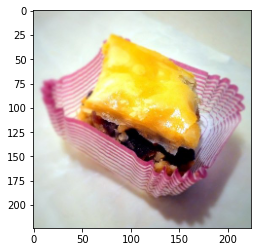

In [ ]:
plt.imshow(img)

In [ ]:
img = load_prep_image('/content/101_food_classes_10_percent/test/macarons/1347603.jpg',224)
print(img)

tf.Tensor(
[[[0.24755903 0.27108845 0.25540218]
  [0.25422168 0.2777511  0.26990795]
  [0.21428572 0.23781513 0.23165265]
  ...
  [0.05309997 0.07270781 0.09007458]
  [0.0304124  0.0421771  0.06178495]
  [0.04095606 0.05272077 0.07232861]]

 [[0.2707883  0.29039615 0.27470988]
  [0.2562625  0.27194878 0.26802722]
  [0.26520607 0.28089234 0.27865145]
  ...
  [0.03995572 0.05956356 0.07693034]
  [0.03451382 0.05412167 0.06980793]
  [0.03277284 0.04453754 0.06414539]]

 [[0.25828332 0.2739696  0.27004802]
  [0.2537615  0.26944777 0.2655262 ]
  [0.23583435 0.2515206  0.24927971]
  ...
  [0.02895151 0.04891947 0.06628624]
  [0.03187284 0.05148068 0.06716696]
  [0.04171679 0.06132464 0.07701091]]

 ...

 [[0.6503004  0.60716313 0.52705127]
  [0.6617447  0.61860746 0.5384956 ]
  [0.65862405 0.6154868  0.5353749 ]
  ...
  [0.79645777 0.73763424 0.6222282 ]
  [0.7911567  0.7323332  0.6186077 ]
  [0.7910381  0.73221457 0.6184891 ]]

 [[0.6688875  0.62575024 0.5473189 ]
  [0.6434176  0.60028034 0

In [ ]:
loaded_model.predict(tf.expand_dims(img,axis=0))

#I dont know why it does not work?

array([[0.02774609, 0.00461122, 0.02342408, 0.00729755, 0.01230263,
        0.03801341, 0.01431497, 0.00509142, 0.01080406, 0.0029413 ,
        0.00336738, 0.00301597, 0.00790924, 0.01243178, 0.00643625,
        0.01100713, 0.00852015, 0.00702074, 0.00242665, 0.01447238,
        0.00737108, 0.00463326, 0.00719448, 0.0219943 , 0.01327197,
        0.00351947, 0.00269147, 0.00566573, 0.00490861, 0.00272245,
        0.00972741, 0.00200567, 0.00168226, 0.01818618, 0.00240687,
        0.00488269, 0.00181072, 0.00505273, 0.003757  , 0.01930757,
        0.00955236, 0.03014721, 0.00192912, 0.00679754, 0.00549111,
        0.00475917, 0.00067216, 0.01158834, 0.00097019, 0.00335528,
        0.00472754, 0.01102764, 0.01594189, 0.00852813, 0.01378119,
        0.00092519, 0.00172093, 0.00233781, 0.003462  , 0.00955352,
        0.02890472, 0.0098298 , 0.01572506, 0.03003458, 0.10320526,
        0.00137118, 0.00821321, 0.00060859, 0.00154207, 0.00539709,
        0.00876142, 0.01068369, 0.00147879, 0.02

## finding the most wrong predictions:

In [ ]:
dataset = tf.data.Dataset.list_files('/content/101_food_classes_10_percent/test/*/*.jpg',shuffle=False)
dataset

<TensorSliceDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>

In [ ]:
filepaths = []

for i in dataset:
  a = i.numpy()
  path = a.decode('ascii')
  filepaths.append(path)

In [ ]:
filepaths[:10]

['/content/101_food_classes_10_percent/test/apple_pie/1011328.jpg',
 '/content/101_food_classes_10_percent/test/apple_pie/101251.jpg',
 '/content/101_food_classes_10_percent/test/apple_pie/1034399.jpg',
 '/content/101_food_classes_10_percent/test/apple_pie/103801.jpg',
 '/content/101_food_classes_10_percent/test/apple_pie/1038694.jpg',
 '/content/101_food_classes_10_percent/test/apple_pie/1047447.jpg',
 '/content/101_food_classes_10_percent/test/apple_pie/1068632.jpg',
 '/content/101_food_classes_10_percent/test/apple_pie/110043.jpg',
 '/content/101_food_classes_10_percent/test/apple_pie/1106961.jpg',
 '/content/101_food_classes_10_percent/test/apple_pie/1113017.jpg']